In [1]:
#######################
# Dimension of images #
#######################
img_width  = 28
img_height = 28
channels   = 1

######################
# Parms for learning #
######################
batch_size = 50
num_epochs = 100
iterations = 3          # number of iterations
nb_augmentation = 2     # defines the number of additional augmentations of one image

####################
#       Data       #
####################
fashion_classes     = {0: 'T-shirt/top',
                       1: 'Trouser',
                       2: 'Pullover',
                       3: 'Dress',
                       4: 'Coat',
                       5: 'Sandal',
                       6: 'Shirt',
                       7: 'Sneaker',
                       8: 'Bag',
                       9: 'Ankle boot'}

mnist_classes       = [i for i in range(10)]
num_classes         = 10

# Setup

In [2]:
import os
import time
import random
import numpy as np
import scipy
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import Input
from keras import layers
from keras.layers import (InputLayer, Add, Dense, Activation, ZeroPadding2D, BatchNormalization,
                          Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,
                          GlobalAveragePooling2D, Dropout)
from keras.initializers import random_uniform, glorot_uniform, constant, identity
from keras.models import Sequential, Model, load_model

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

# Loading data

In [3]:
# Train
train_fasion_mnist = tfds.as_numpy(tfds.load("fashion_mnist", split="train", batch_size=-1))
X_train, y_train   = train_fasion_mnist["image"], train_fasion_mnist["label"]

# Test
test_fasion_mnist  = tfds.as_numpy(tfds.load("fashion_mnist", split="test", batch_size=-1))
X_test, y_test     = test_fasion_mnist["image"], test_fasion_mnist["label"]

print("Train Samples:", len(X_train))
print("Test Samples:",  len(X_test))

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteRUCOHS/fashion_mnist-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteRUCOHS/fashion_mnist-test.tfrecord*...:   0%…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.
Train Samples: 60000
Test Samples: 10000


# Plot random samples

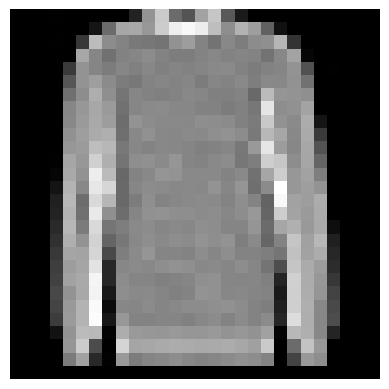

Target: Pullover


In [4]:
idx = np.random.randint(len(X_train))
plt.imshow(np.squeeze(X_train[idx]), cmap='gray')
plt.axis('off')
plt.show()

print("Target:", fashion_classes[y_train[idx]])

# Data Augmentation

In [5]:
# Defines the options for augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    horizontal_flip=True,
    fill_mode='nearest'
)

def image_augmentation(image, nb_of_augmentation):
    '''
    Generates new images bei augmentation
    image : raw image
    nb_augmentation: number of augmentations
    images: array with new images
    '''
    images = []
    image = image.reshape(1, img_height, img_width, channels)
    i = 0
    for x_batch in datagen.flow(image, batch_size=1):
        images.append(x_batch)
        i += 1
        if i >= nb_of_augmentation:
            # interrupt augmentation
            break
    return images

# Preprocess Data

In [6]:
def preprocess_data(images, targets, use_augmentation=False, nb_of_augmentation=1):
    """
    images: raw image
    targets: target label
    use_augmentation: True if augmentation should be used
    nb_of_augmentation: If use_augmentation=True, number of augmentations
    """
    X = []
    y = []
    for x_, y_ in zip(images, targets):

        # scaling pixels between 0.0-1.0
        x_ = x_ / 255.

        # data Augmentation
        if use_augmentation:
            argu_img = image_augmentation(x_, nb_of_augmentation)
            for a in argu_img:
                X.append(a.reshape(img_height, img_width, channels))
                y.append(y_)

        X.append(x_)
        y.append(y_)
    print('*Preprocessing completed: %i samples\n' % len(X))
    return np.array(X), tf.keras.utils.to_categorical(y)

In [7]:
X_train_shaped, y_train_shaped = preprocess_data(
    X_train, y_train,
    use_augmentation=True,
    nb_of_augmentation=nb_augmentation
)

X_test_shaped, y_test_shaped = preprocess_data(X_test, y_test)

*Preprocessing completed: 180000 samples

*Preprocessing completed: 10000 samples



## Helper codes

In [8]:
def identity_block(X, f, filters, training=True, initializer=random_uniform):
    """
    Implementation of the identity block

    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to random uniform initializer

    Returns:
    X -- output of the identity block, tensor of shape (m, n_H, n_W, n_C)
    """

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value. We'll need this later to add back to the main path.
    X_shortcut = X

    # First component of main path
    X = Conv2D(filters=F1, kernel_size=1, strides=(1, 1), padding='valid', kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X, training=training)  # Default axis
    X = Activation('relu')(X)

    ## Second component of main path
    ## Set the padding = 'same'
    X = Conv2D(filters=F2, kernel_size=f, strides=(1, 1), padding='same', kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)

    ## Third component of main path
    ## Set the padding = 'valid'
    X = Conv2D(filters=F3, kernel_size=1, strides=(1, 1), padding='valid', kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X, training=training)

    ## Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)

    return X

def convolutional_block(X, f, filters, s=2, training=True, initializer=glorot_uniform):
    """
    Implementation of the convolutional block

    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to Glorot uniform initializer,
                   also called Xavier uniform initializer.

    Returns:
    X -- output of the convolutional block, tensor of shape (m, n_H, n_W, n_C)
    """

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value
    X_shortcut = X

    ##### MAIN PATH #####

    # First component of main path glorot_uniform(seed=0)
    X = Conv2D(filters=F1, kernel_size=1, strides=(s, s), padding='valid', kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)

    ## Second component of main path
    X = Conv2D(filters=F2, kernel_size=f, strides=(1, 1), padding='same', kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)

    ## Third component of main path
    X = Conv2D(filters=F3, kernel_size=1, strides=(1, 1), padding='valid', kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X, training=training)

    ##### SHORTCUT PATH #####
    X_shortcut = Conv2D(filters=F3, kernel_size=1, strides=(s, s), padding='valid',
                        kernel_initializer=initializer(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3)(X_shortcut, training=training)

    # Final step: Add shortcut value to main path (Use this order [X, X_shortcut]),
    # and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

def create_resnet50(input_shape, classes):
    """
    Stage-wise implementation of the architecture of the popular ResNet50:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], s=1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])

    # Stage 3
    # `convolutional_block` with correct values of `f`, `filters` and `s` for this stage
    X = convolutional_block(X, f=3, filters=[128, 128, 512], s=2)
    # the 3 `identity_block` with correct values of `f` and `filters` for this stage
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])

    # Stage 4
    # add `convolutional_block` with correct values of `f`, `filters` and `s` for this stage
    X = convolutional_block(X, f=3, filters=[256, 256, 1024], s=2)
    # the 5 `identity_block` with correct values of `f` and `filters` for this stage
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])

    # Stage 5
    # add `convolutional_block` with correct values of `f`, `filters` and `s` for this stage
    X = convolutional_block(X, f=3, filters=[512, 512, 2048], s=2)
    # the 2 `identity_block` with correct values of `f` and `filters` for this stage
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])

    # AVGPOOL. Use "X = AveragePooling2D()(X)"
    X = AveragePooling2D((1, 1))(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer=glorot_uniform(seed=0))(X)

    # Create model
    model = Model(inputs=X_input, outputs=X)

    return model

# Train

In [9]:
histories = []
for i in range(0,iterations):
    print('Running iteration: %i' % i)

    # Saving the best checkpoint for each iteration
    filepath = "fashion_mnist_ResNet50-%i.hdf5" % i

    X_train_, X_val_, y_train_, y_val_ = train_test_split(X_train_shaped, y_train_shaped,
                                                          test_size=0.2, random_state=42)

    cnn = create_resnet50(input_shape = (img_height, img_width, channels), classes = num_classes)
    cnn.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = ['accuracy'])
    tick = time.perf_counter()
    history = cnn.fit(
        X_train_, y_train_,
        batch_size=batch_size,
        epochs=num_epochs,
        verbose=1,
        validation_data=(X_val_, y_val_),
        callbacks=[
            tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.05, patience=10, start_from_epoch=50, verbose=1, mode='max'),  
            tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True)
        ]
    )
    tock = time.perf_counter()
    histories.append(history.history)
    print(f"Time to train model {i+1}: {(tock-tick)/60:.2f} minutes.")

Running iteration: 0
Epoch 1/100
2880/2880 [==============================] - ETA: 0s - loss: 0.9393 - accuracy: 0.7243
Epoch 1: val_loss improved from inf to 0.50359, saving model to fashion_mnist_ResNet50-0.hdf5
2880/2880 [==============================] - 156s 39ms/step - loss: 0.9393 - accuracy: 0.7243 - val_loss: 0.5036 - val_accuracy: 0.8177
Epoch 2/100
2879/2880 [============================>.] - ETA: 0s - loss: 0.4390 - accuracy: 0.8406
Epoch 2: val_loss improved from 0.50359 to 0.37095, saving model to fashion_mnist_ResNet50-0.hdf5
2880/2880 [==============================] - 110s 38ms/step - loss: 0.4389 - accuracy: 0.8406 - val_loss: 0.3710 - val_accuracy: 0.8617
Epoch 3/100
2879/2880 [============================>.] - ETA: 0s - loss: 0.3753 - accuracy: 0.8641
Epoch 3: val_loss improved from 0.37095 to 0.36172, saving model to fashion_mnist_ResNet50-0.hdf5
2880/2880 [==============================] - 110s 38ms/step - loss: 0.3753 - accuracy: 0.8641 - val_loss: 0.3617 - val_a

# Evaluation

## Training scores for loss and accuracy for all checkpoints

In [10]:
def get_avg(histories, his_key):
    tmp = []
    for history in histories:
        tmp.append(history[his_key][np.argmin(history['val_loss'])])
    return np.mean(tmp)

print('Training: \t%0.8f loss / %0.8f acc'   % (get_avg(histories,'loss'), get_avg(histories,'accuracy')))
print('Validation: \t%0.8f loss / %0.8f acc' % (get_avg(histories,'val_loss'), get_avg(histories,'val_accuracy')))

Training: 	0.09052109 loss / 0.96738195 acc
Validation: 	0.18536321 loss / 0.94205556 acc


## Loss / accuracy of all models on testset

In [11]:
test_loss = []
test_accs = []

for i in range(0,iterations):
    cnn_ = tf.keras.models.load_model("fashion_mnist_ResNet50-%i.hdf5" % i)

    score = cnn_.evaluate(X_test_shaped, y_test_shaped, verbose=0)
    test_loss.append(score[0])
    test_accs.append(score[1])

    print('Running final test with model %i: %0.4f loss / %0.4f acc' % (i,score[0],score[1]))

print('\nAverage loss / accuracy on testset: %0.4f loss / %0.5f acc' % (np.mean(test_loss),np.mean(test_accs)))
print('Standard deviation: (+-%0.4f) loss / (+-%0.4f) acc' % (np.std(test_loss),np.std(test_accs)))

Running final test with model 0: 0.3597 loss / 0.9172 acc
Running final test with model 1: 0.3113 loss / 0.9200 acc
Running final test with model 2: 0.3288 loss / 0.9171 acc

Average loss / accuracy on testset: 0.3333 loss / 0.91810 acc
Standard deviation: (+-0.0200) loss / (+-0.0013) acc


## Plotting accuracy and loss for each iteration

In [12]:
def plot_acc_loss(title, histories, key_acc, key_loss):
    fig, (ax1, ax2) = plt.subplots(1, 2)

    # Accuracy
    ax1.set_title('Model accuracy (%s)' % title)
    names = []
    for i, model in enumerate(histories):
        ax1.plot(model[key_acc])
        ax1.set_xlabel('epoch')
        names.append('Model %i' % i)
        ax1.set_ylabel('accuracy')
    ax1.legend(names, loc='upper left')

    # Loss
    ax2.set_title('Model loss (%s)' % title)
    for model in histories:
        ax2.plot(model[key_loss])
        ax2.set_xlabel('epoch')
        ax2.set_ylabel('loss')
    ax2.legend(names, loc='upper right')
    fig.set_size_inches(20, 5)
    plt.show()

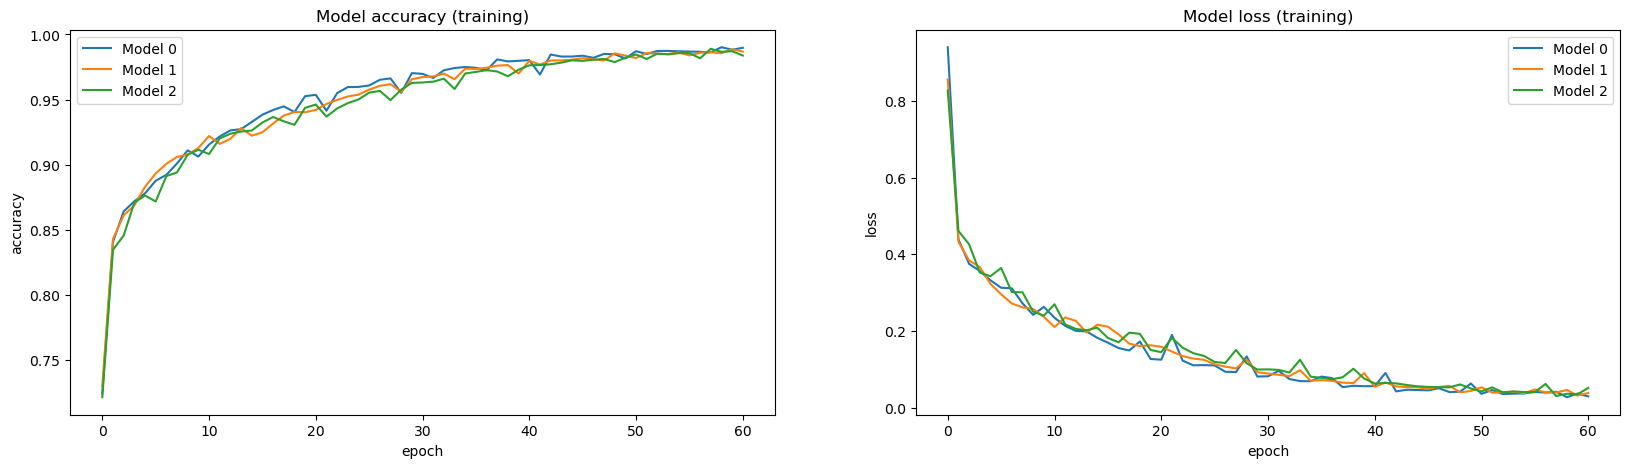

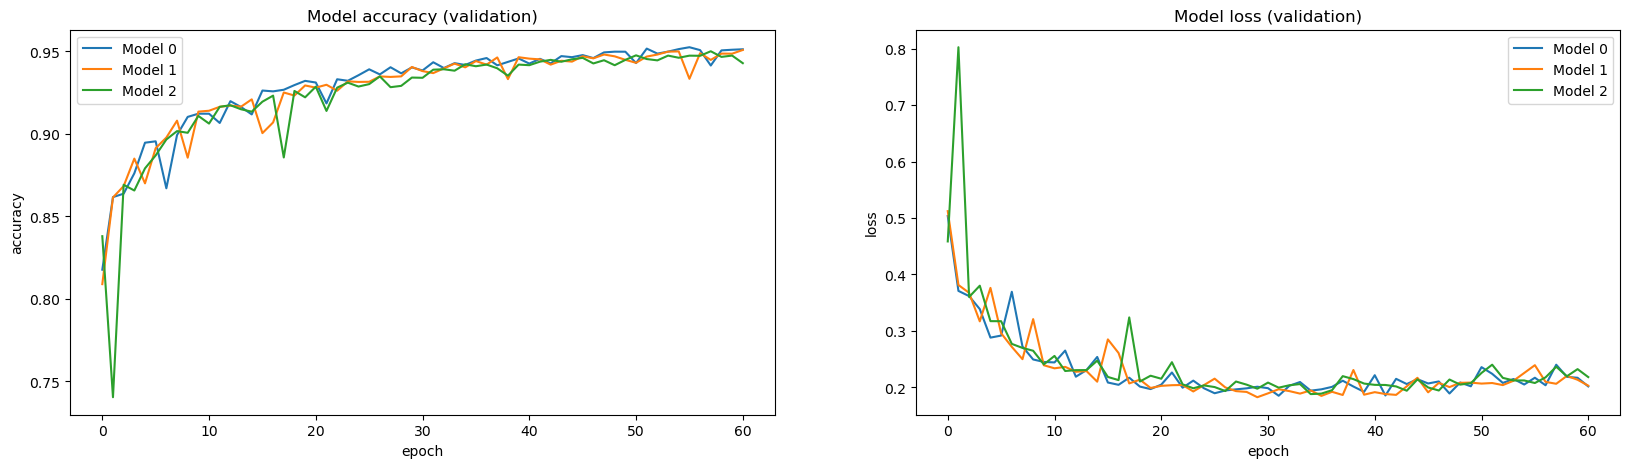

In [13]:
plot_acc_loss('training', histories, 'accuracy', 'loss')
plot_acc_loss('validation', histories, 'val_accuracy', 'val_loss')

## Evaluation for one model

In [14]:
RUN = 0 # you can choose one of the different models trained above
model = create_resnet50(input_shape = (img_height, img_width, channels), classes = num_classes)
model.load_weights("fashion_mnist_ResNet50-%i.hdf5" % RUN)

### Plotting accuracy and loss for one model

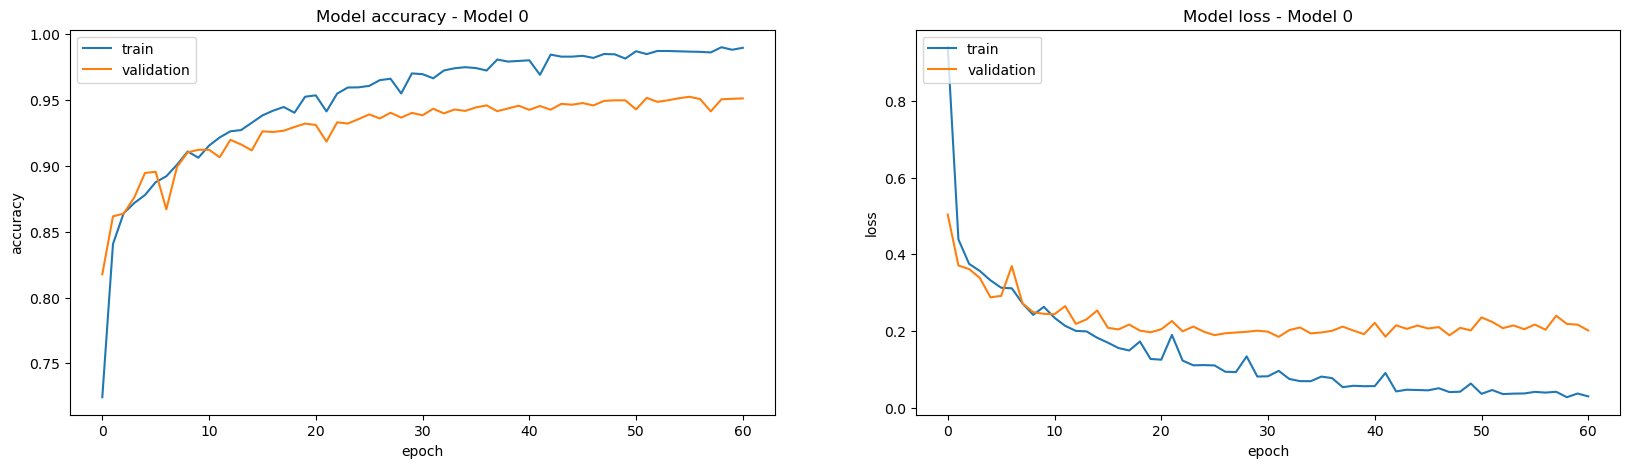

In [15]:
def plot_train_val(title, history):
    fig, (ax1, ax2) = plt.subplots(1, 2)

    # Accuracy
    ax1.set_title('Model accuracy - %s' % title)
    ax1.plot(history['accuracy'])
    ax1.plot(history['val_accuracy'])
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('accuracy')
    ax1.legend(['train', 'validation'], loc='upper left')

    # Loss
    ax2.set_title('Model loss - %s' % title)
    ax2.plot(history['loss'])
    ax2.plot(history['val_loss'])
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('loss')
    ax2.legend(['train', 'validation'], loc='upper left')

    fig.set_size_inches(20, 5)
    plt.show()
    
plot_train_val('Model %i' % RUN, histories[RUN])

## Displaying results of random predictions

1/1 [==============================] - 0s 21ms/step


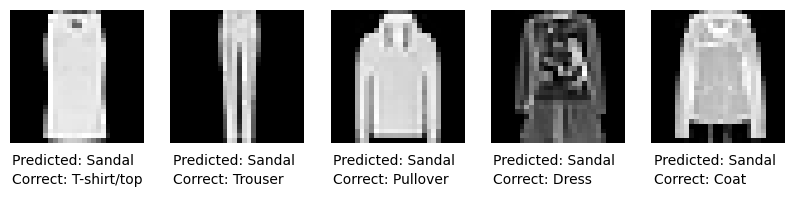

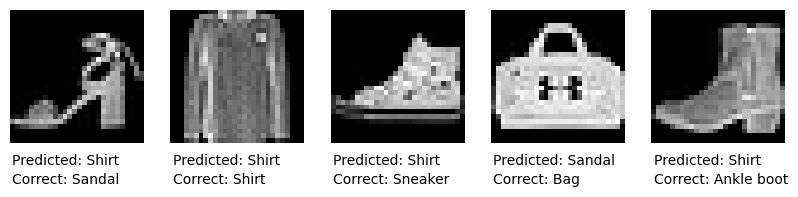

In [16]:
def plot_sample_predictions(classes, model, X_test, y_test):
    """
    This function displays images randomly and tries to predict the correct class
    """

    class_ = 0
    images_per_row = 5
    rows = len(classes) // images_per_row

    for i in range(rows):
        fig, axis = plt.subplots(1, images_per_row)

        for i, axis in enumerate(axis):

            elements = np.squeeze(np.argwhere(y_test==class_))
            random   = np.random.randint(len(elements))

            X = X_test[elements[random]]
            y = y_test[elements[random]]

            fig.set_size_inches(10, 20)

            x_reshape = X.reshape([1,img_height,img_width,channels])
            axis.text(0,32,'Predicted: {}'.format(classes[np.argmax(model.predict(x_reshape))]))
            axis.text(0,36,'Correct: {}'.format((classes)[y]))
            axis.imshow(np.squeeze(X), cmap='gray')
            axis.axis('off')
            class_ +=1
    plt.show()

plot_sample_predictions(list(fashion_classes.values()), model, X_test_shaped, y_test)

## Plotting confusion matrix

In [17]:
def plot_confusion_matrix(cm, class_, title='Confusion matrix', cmap=plt.cm.Reds):
    """
    This function plots a confusion matrix
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(class_))
    plt.xticks(tick_marks, class_, rotation=90)
    plt.yticks(tick_marks, class_)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i,j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True labels')
    plt.xlabel('Predicted labels')
    plt.show()

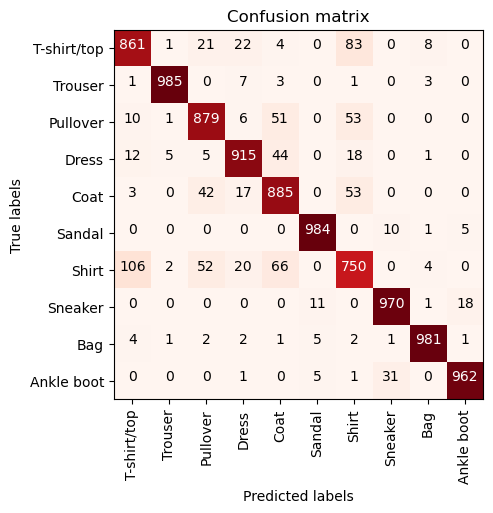

In [18]:
predictions = model.predict(X_test_shaped, verbose=0)
classes = np.argmax(predictions,axis=1)
plot_confusion_matrix(confusion_matrix(y_test, classes), list(fashion_classes.values()))

## Report of f1, precision and recall

In [19]:
print(classification_report(y_test, classes))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86      1000
           1       0.99      0.98      0.99      1000
           2       0.88      0.88      0.88      1000
           3       0.92      0.92      0.92      1000
           4       0.84      0.89      0.86      1000
           5       0.98      0.98      0.98      1000
           6       0.78      0.75      0.76      1000
           7       0.96      0.97      0.96      1000
           8       0.98      0.98      0.98      1000
           9       0.98      0.96      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000

